In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib.ticker as ticker
import time
import pandas as pd 
import numpy as np
import random
import time
import subprocess
from collections import namedtuple,defaultdict
import matplotlib.pyplot as plt 
import logging
import json
import os
import yaml
import gym
import sys
import threading
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
%load_ext tensorboard


In [ ]:
# path_data = '/content/drive/MyDrive/Projet_OCO/data/'
path_data = '/content/drive/MyDrive/OCO/data/'

In [ ]:
mnist_train = pd.read_csv(path_data+"mnist_train.csv",header=None)
mnist_test = pd.read_csv(path_data+"mnist_test.csv",header=None)

y_train = mnist_train.loc[:,0].to_numpy()
y_test = mnist_test.loc[:,0].to_numpy()
X_train = mnist_train.loc[:,1:].to_numpy()
X_test = mnist_test.loc[:,1:].to_numpy()


# normalisation
X_train = X_train/255.
X_test = X_test/255.

# 0 vs others

y_train = 2 * (y_train == 0) - 1
y_test = 2 * (y_test == 0) - 1


# Vector preparation : on rajoute une ligne de 1 pour ne pas avoir a expliciter le biais
X_train = np.concatenate([X_train, np.ones((len(X_train), 1))], axis=1)
X_test = np.concatenate([X_test, np.ones((len(X_test), 1))], axis=1)

#UTILS

In [ ]:
#A mettre dans un fichier.py

import time
import subprocess
from collections import namedtuple,defaultdict
import logging
import json
import os
import yaml
import gym
import sys
import threading
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
%load_ext tensorboard

def loadTensorBoard(outdir):
    t = threading.Thread(target=launchTensorBoard, args=([outdir]))
    t.start()

def launchTensorBoard(tensorBoardPath):
    print('tensorboard --logdir=' + tensorBoardPath)
    ret=os.system('tensorboard --logdir='  + tensorBoardPath)
    if ret!=0:
        syspath = os.path.dirname(sys.executable)
        print(os.path.dirname(sys.executable))
        ret = os.system(syspath+"/"+'tensorboard --logdir=' + tensorBoardPath)
    return


class LogMe(dict):
    def __init__(self,writer,term=True):
        self.writer = writer
        self.dic = defaultdict(list)
        self.term = term
    def write(self,i):
        if len(self.dic)==0: return
        s=f"Epoch {i} : "
        for k,v in self.dic.items():
            self.writer.add_scalar(k,sum(v)*1./len(v),i)
            s+=f"{k}:{sum(v)*1./len(v)} -- "
        self.dic.clear()
        if self.term: logging.info(s)
    def update(self,l):
        for k,v in l:
            self.add(k,v)
    def direct_write(self,k,v,i):
        self.writer.add_scalar(k,v,i)
    def add(self,k,v):
        self.dic[k].append(v)




def prs(*args):
    st = ""
    for s in args:
        st += str(s)
    print(st)


class DotDict(dict):
    """dot.notation access to dictionary attributes (Thomas Robert)"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def load_yaml(path):
    with open(path, 'r') as stream:
        opt = yaml.load(stream,Loader=yaml.Loader)
    return DotDict(opt)

def write_yaml(file,dotdict):
    d=dict(dotdict)
    with open(file, 'w', encoding='utf8') as outfile:
        yaml.dump(d, outfile, default_flow_style=False, allow_unicode=True)


def init(algoName,
         #config_file,
         ):
    #config = load_yaml(config_file)
    

    now = datetime.now()
    date_time = now.strftime("%d-%m-%Y-%HH%M-%SS")
    outdir = "./XP/" + algoName + "_" + date_time

    print("Saving in " + outdir)
    os.makedirs(outdir, exist_ok=True)
    #save_src(os.path.abspath(outdir))
    #write_yaml(os.path.join(outdir, 'config.yaml'), config)
    logger = LogMe(SummaryWriter(outdir))
    loadTensorBoard(outdir)

    return outdir, logger #config_file, 


def Logger(logger,loss,train_err,test_err,t,eta_t=None):

  logger.direct_write('Loss',loss,t)
  logger.direct_write('Train/Error',train_err,t)
  logger.direct_write('Test/Error',test_err,t)
  if eta_t is not None:
    logger.direct_write('Eta',eta_t,t)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import time 
def time_it(function):
    def wrapper(*args,**kwargs):
        begin = time.time()
        result = function(*args,**kwargs)
        end = time.time()
        print("\n"+function.__name__ + " a mis : {} ms".format((end-begin)*1000))
        return result, (end-begin)*1000
    return wrapper


def reg_hinge_loss(a,b,x,alpha=0,direction=None,test=False): #fourni la loss regularisé,le gradient et l'accuracy
    batch_size = len(b)
    n,d = a.shape
    #Loss
    product = a.dot(x)
    margin = 1 - b*product
    loss = np.maximum(np.zeros(batch_size), margin).mean() + 0.5 * alpha * x.dot(x)
    #Grad
    mask = (margin>0)
    if(test==True):
      grad=0
    else:
      if(direction==None):
        grad = -(1/n)*(mask*b).dot(a) + alpha*x
      else:
        grad = (-(mask*b)*a[0,direction] + alpha*x[direction])[0]
    #Accuracy
    predict = np.sign(product)
    correct = np.sum(b == predict)
    accuracy =  correct / batch_size
    return loss, grad, accuracy


def simplex_proj(x):
    x_s = np.sort(x, kind='quicksort')[::-1]
    cum_s = np.cumsum(x_s)
    res = x_s - (cum_s-1)/(np.arange(len(x))+1)
    d0 = np.max(np.where(res>0)[0]) + 1
    theta = (cum_s[d0-1] -1)/d0

    return np.maximum(0,x-theta)

def weighted_simplex_proj(x,D):
    """
    x : vector, D : diag matrix
    """
    dx = np.abs(np.dot(D,x))
    sorted_indices = np.argsort(-dx, kind='quicksort')
    sx = np.cumsum(x[sorted_indices])
    sd = np.cumsum(1/np.diag(D)[sorted_indices])
    res = dx[sorted_indices] - (sx-1)/sd
    d0 = np.max(np.where(res>0)[0])
    theta = (sx[d0]-1)/sd[d0]

    return np.dot(np.linalg.inv(D),np.maximum(0,dx-theta))

def l1_ball_proj(x,z=1,D=None):
    if sum(abs(x)) <= z:
        return x
    else:
        if D is not None:
            w = weighted_simplex_proj(abs(x)/z,D)
        else :
            w = simplex_proj(abs(x)/z)
        return z*np.sign(x)*w

#ALGOS

In [ ]:
@time_it
def GD(a, b, a_test, b_test, T, alpha):
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    
    errors_test = np.zeros(T)
    outdir,logger = init("GD")
    for t in tqdm(range(1, T + 1)):
      if alpha == 0:
          eta_t = 1 / np.sqrt(t)
      else:
          eta_t = 1 / (alpha * t)
      l_train, grad, acc_train = reg_hinge_loss(a,b,x,alpha)
      l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x,alpha,test=True)
      errors_test[t-1] = 1-acc_test
      Logger(logger,
            l_train,
            1-acc_train,
            1-acc_test,
            t,
            eta_t)
      x -= eta_t * grad
    return outdir,errors_test


@time_it
def GDproj(a, b, a_test, b_test, T, alpha,radius):
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    errors_test = np.zeros(T)
    outdir,logger = init("GDproj")
    for t in tqdm(range(1, T + 1)):
      if alpha == 0:
          eta_t = 1 / np.sqrt(t)
      else:
          eta_t = 1 / (alpha * t)
      l_train, grad, acc_train = reg_hinge_loss(a,b,x,alpha)
      l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x,alpha,test=True)
      errors_test[t-1] = 1-acc_test
      Logger(logger,
            l_train,
            1-acc_train,
            1-acc_test,
            t,
            eta_t)
      x -= eta_t * grad
      x = l1_ball_proj(x,radius)
    return outdir,errors_test

In [ ]:
@time_it
def SGD(a, b, a_test, b_test, T, alpha):
    np.random.seed(42)
    n, d = a.shape
    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    errors_test = np.zeros(T)
    
    outdir,logger = init("SGD")
    t_ = 0 
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        if alpha == 0:
            # our problem is convex (as the hinge loss is a convex function)
            eta_t = 1 / np.sqrt(t)
        else:
            eta_t = 1 / (alpha * t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)

        
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True)
        errors_test[t-1] = 1-acc_test
        
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
     
  
        x -= eta_t * grad

        # averaging
        x_avg = (x_avg * (t - 1) + x) / t
        
    return outdir,errors_test

@time_it
def SGDproj(a, b, a_test, b_test, T, alpha, radius):
    np.random.seed(42)
    n, d = a.shape
    # x is weight (online version)
    x = np.zeros(d)
    x_avg = np.zeros(d)
    errors_test = np.zeros(T)
    
    outdir,logger = init("SGDproj")

    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        if alpha == 0:
            # our problem is convex (as the hinge loss is a convex function)
            eta_t = 1 / np.sqrt(t)
        else:
            eta_t = 1 / (alpha * t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
  
        x -= eta_t * grad
        x = l1_ball_proj(x,radius)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t
        
    return outdir,errors_test


In [ ]:
@time_it
def SMD(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)

    errors_test = np.zeros(T)
    outdir,logger = init("SMDproj")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        

        y -=  eta_t * grad #Lazy version 
        x = l1_ball_proj(y,radius)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test


@time_it
def SEGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    theta = np.zeros(2 * d)
    w = np.ones(2*d)/(2*d)
    errors_test = np.zeros(T)
    outdir,logger = init("SEGpm")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        theta[:d] -= eta_t * grad
        theta[d:] += eta_t * grad

        w = np.exp(theta)/sum(np.exp(theta))
        x = radius * (w[:d] - w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test


@time_it
def ADAproj(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)
    S = np.ones(d) * 1e-4
    errors_test = np.zeros(T)
    outdir,logger = init("Adaproj")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        
        y = x - eta_t*np.dot(Dinv,grad)
        x = l1_ball_proj(y,radius,D)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test

In [ ]:
@time_it
def ONS(a, b, a_test, b_test, T, alpha, radius, gamma):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)
    A = (1/gamma**2)*np.eye(d)
    Ainv = (gamma**2)*np.eye(d)
    
    errors_test = np.zeros(T)
    outdir,logger = init("ONS")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t)
        
        grad_matrix = np.outer(grad,grad)
        A += grad_matrix
       
        Ainv = np.linalg.inv(A)
        y = x - (1/gamma)*np.dot(Ainv,grad) # multiple learning rate step
    
        # weighted proj
        x = l1_ball_proj(y,radius,np.diag(np.diag(A)))
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test

In [ ]:
@time_it
def SREGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("SREGpm")
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)
        expert = np.random.choice(np.arange(d), 1, p=(w[:d]+w[d:]))

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,expert)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        if grad > 0:
            w[expert] = np.exp(-(eta_t*grad)/w[expert])*w[expert]
        else:
            w[expert+d] = np.exp((eta_t*grad)/w[expert+d])*w[expert+d]

        w = np.nan_to_num(w)
        w /= sum(w)
        x = radius*(w[:d]-w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir, errors_test


@time_it
def SBEGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("SBEGpm")
    for t in tqdm(range(1, T + 1)):

        A = np.random.choice(np.arange(2*d), 1, p = w)
        j = A*(A<=d)+(A-d)*(A>d) 
        s = 1-2*(A>d) 
        
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(2*d*t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,j)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)


        w[A] = np.exp(- s*eta_t * grad / w[A])
        w = np.nan_to_num(w)
        w = (1-eta_t)*(w / np.sum(w)) + (eta_t/(2*d))

        x = radius * (w[:d] - w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir, errors_test


@time_it
def Exp2(a, b, a_test, b_test, T, gamma, eta): #NE FONCTiONNE PAS 
    np.random.seed(42)
    n, d = a.shape
    eta_0 = (1/(2*d))
    eta_past = eta_0
    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    w1 = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("Exp2")
    for t in tqdm(range(1, T + 1)):
        p = (1-gamma)*(w/sum(w)) + (gamma/(2*d))*np.ones(2*d)
        A = np.random.choice(np.arange(2*d), 1, p=p)[0]
        j = A*(A<=d)+(A-d)*(A>d) 
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,j)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t)
        
        w[A] = np.exp(-eta*grad/(2*d*p[A])) * w[A]
        w = np.nan_to_num(w)
        x = w[:d] - w[d:]
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

  
    return outdir, errors_test

In [ ]:
def run(): #tester plusieurs hyperparametres
  T = 10000 #mettre 10000
  alpha = 1/3
  radius = 100 
  gamma = 1/8
  eta = 0.000007
  a,b,a_test,b_test = X_train,y_train,X_test,y_test
  algos = [GD,GDproj,SGD, SGDproj, SMD, SEGpm ,ADAproj, ONS,  SREGpm, SBEGpm]#, Exp2]
  args = [(a, b, a_test, b_test, T, alpha), #GD
          (a, b, a_test, b_test, T, alpha, radius), #GDproj
          (a, b, a_test, b_test, T, alpha), #SGD
          (a, b, a_test, b_test, T, alpha, radius), #SGDproj
          (a, b, a_test, b_test, T, radius), #SMD
          (a, b, a_test, b_test, T, radius), #SEGpm
          (a, b, a_test, b_test, T, radius), #ADAproj
          (a, b, a_test, b_test, T, alpha, radius, gamma), #ONS
          (a, b, a_test, b_test, T,radius), #SREGpm
          #(a, b, a_test, b_test, T,radius), #SBEGpm
          #(a, b, a_test, b_test, T,gamma,eta), #Exp2
          ]
  outdirs = []
  names = ["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm", "SBEGpm"]#,"Exp2"] 
  errors = []
  times = []
  for algo,arg in zip(algos,args):
    
    (outdir,errors_test),time_ = algo(*arg)
    outdirs.append(outdir)
    #names.append(name)
    errors.append(errors_test)
    times.append(time_)

  return outdirs,names,errors,times

In [ ]:
outdirs,names,errors,times = run()

Saving in ./XP/GD_02-01-2022-04H54-03S
tensorboard --logdir=./XP/GD_02-01-2022-04H54-03S


100%|██████████| 10000/10000 [15:39<00:00, 10.64it/s]



GD a mis : 942280.0190448761 ms
Saving in ./XP/GDproj_02-01-2022-05H09-45S
tensorboard --logdir=./XP/GDproj_02-01-2022-05H09-45S

  0%|          | 1/10000 [00:00<19:24,  8.59it/s]

100%|██████████| 10000/10000 [15:37<00:00, 10.67it/s]



GDproj a mis : 937280.9705734253 ms
Saving in ./XP/SGD_02-01-2022-05H25-22S
tensorboard --logdir=./XP/SGD_02-01-2022-05H25-22S


100%|██████████| 10000/10000 [01:26<00:00, 115.14it/s]



SGD a mis : 86906.30269050598 ms
Saving in ./XP/SGDproj_02-01-2022-05H26-49S
tensorboard --logdir=./XP/SGDproj_02-01-2022-05H26-49S

  0%|          | 8/10000 [00:00<02:12, 75.37it/s]

100%|██████████| 10000/10000 [01:33<00:00, 106.94it/s]



SGDproj a mis : 93529.87360954285 ms
Saving in ./XP/SMDproj_02-01-2022-05H28-23S
tensorboard --logdir=./XP/SMDproj_02-01-2022-05H28-23S

  0%|          | 6/10000 [00:00<02:50, 58.60it/s]

100%|██████████| 10000/10000 [01:36<00:00, 103.91it/s]



SMD a mis : 96258.41927528381 ms
Saving in ./XP/SEGpm_02-01-2022-05H29-59S
tensorboard --logdir=./XP/SEGpm_02-01-2022-05H29-59S

  0%|          | 9/10000 [00:00<01:55, 86.52it/s]

100%|██████████| 10000/10000 [01:37<00:00, 102.12it/s]



SEGpm a mis : 97943.55487823486 ms
Saving in ./XP/Adaproj_02-01-2022-05H31-37S
tensorboard --logdir=./XP/Adaproj_02-01-2022-05H31-37S

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [03:19<00:00, 50.14it/s]



ADAproj a mis : 199496.9186782837 ms
Saving in ./XP/ONS_02-01-2022-05H34-56S
tensorboard --logdir=./XP/ONS_02-01-2022-05H34-56S

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [15:02<00:00, 11.08it/s]



ONS a mis : 902645.4162597656 ms
Saving in ./XP/SREGpm_02-01-2022-05H49-59S
tensorboard --logdir=./XP/SREGpm_02-01-2022-05H49-59S

  0%|          | 7/10000 [00:00<02:35, 64.23it/s]

100%|██████████| 10000/10000 [01:42<00:00, 97.71it/s]


SREGpm a mis : 102376.12557411194 ms


In [ ]:
def save_errors():
  for arr,name in zip(errors,names):
    np.save(name,arr)

In [ ]:
errors[0]

array([1.    , 0.098 , 0.098 , ..., 0.0201, 0.0201, 0.0201])

GD vs GDproj

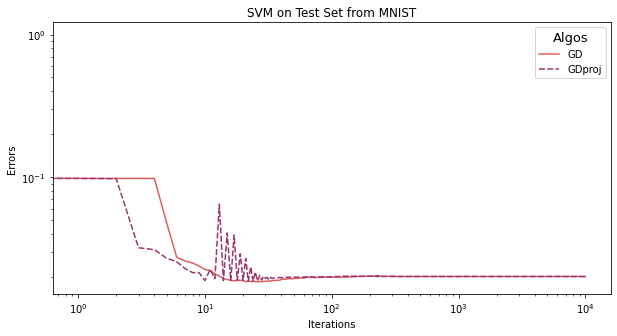

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors[:2], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["GD","GDproj"])
plt.show()

SGD vs GD

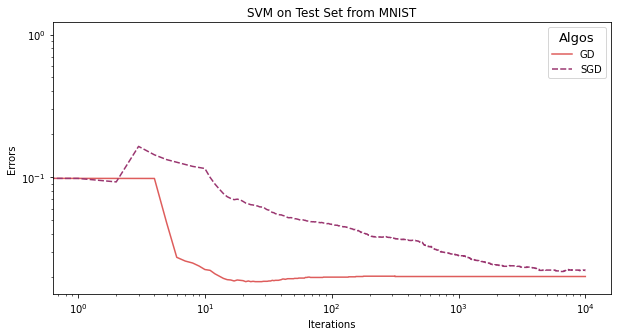

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=[errors[0],errors[2]], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm"])
plt.show()

SGD vs SGDproj

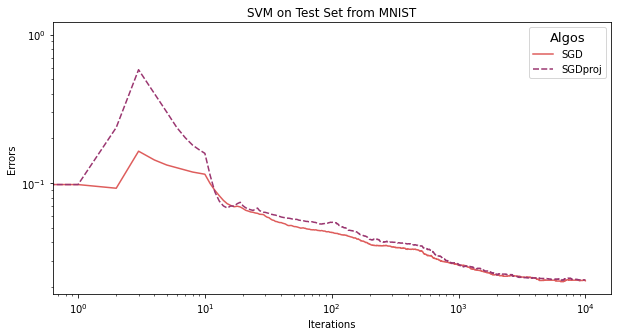

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors[2:4], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SGD","SGDproj"])
plt.show()

SGDproj vs GDproj

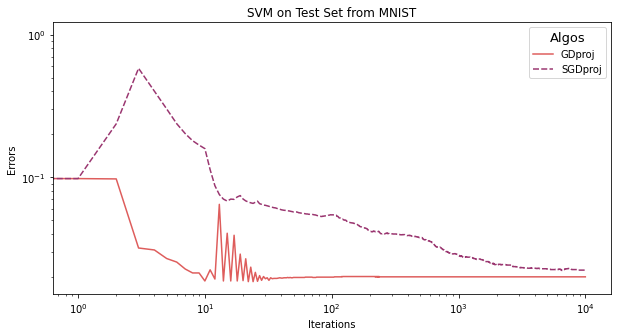

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=[errors[1],errors[3]], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["GDproj","SGDproj"])
plt.show()

SMD vs SGDproj

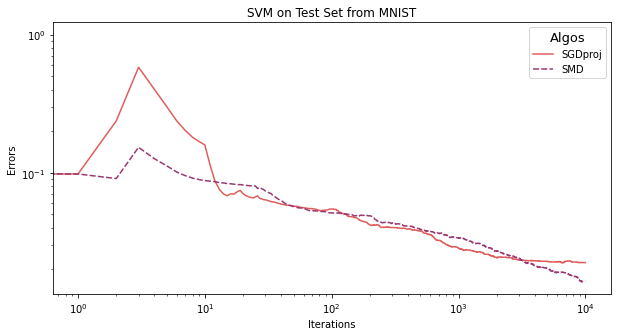

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=[errors[3],errors[4]], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SGDproj","SMD"])
plt.show()

SEG vs SGDproj

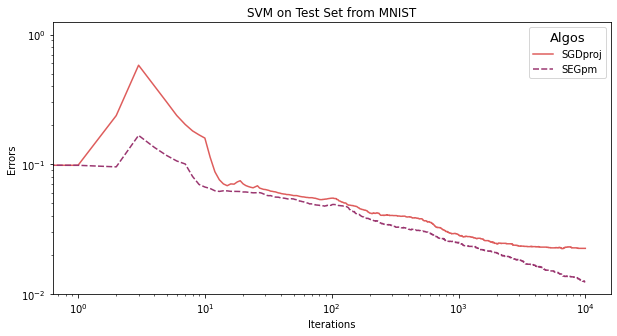

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=[errors[3],errors[5]], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SGDproj","SEGpm"])
plt.show()

ADAproj vs SGDproj

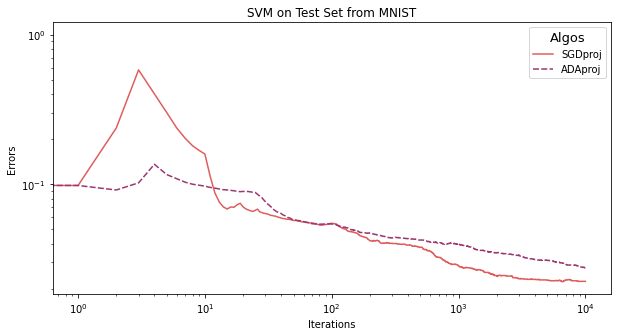

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=[errors[3],errors[6]], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SGDproj","ADAproj"])
plt.show()

ONS vs SGDproj vs SMD vs SEG vs ADAproj

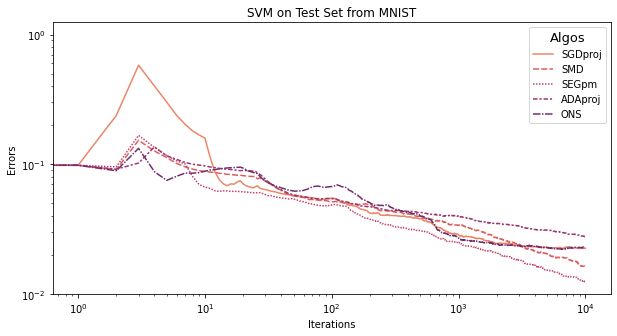

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors[3:8], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SGDproj","SMD", "SEGpm" ,"ADAproj", "ONS"])
plt.show()

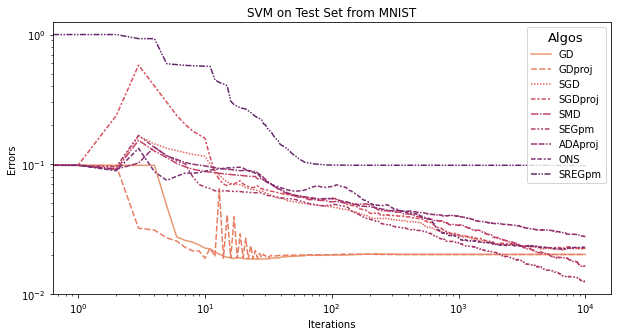

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors, linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm"])
plt.show()

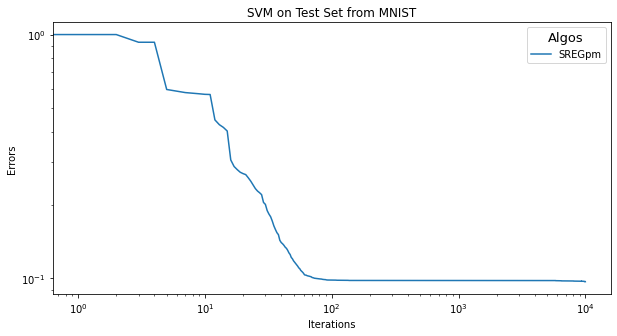

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors[8], linewidth=1.5,legend=False,palette="flare")
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["SREGpm"])
plt.show()